# Regression Tree

It's time to design our generic regression tree model that can be applied to any player. It will be based on the regression tree we designed using Federer as an exemple.

In [336]:
### IMPORTS ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

We select the player and generate a table containing that player's matches which we will store in "player.csv", as to avoid creating one table for each player.  
Note : This setup step has to be repeated each time we change players.

In [337]:
### CLEAN PLAYER MATCHES TABLES ###

PLAYER = "Alexander Zverev"
setup = False

if (setup) :    # Creating the table (if the player.csv table currently contains information for another player)

    atp = pd.read_csv("atp_cat.csv")
    # atp = atp[atp.loser_hand != 'U']
    # atp.to_csv("atp_cat.csv", index=False)

    player_won = atp[atp["winner_name"] == PLAYER]
    player_lost = atp[atp["loser_name"] == PLAYER]

    # We'll drop all of the player's information except his age and rank
    player_won = player_won.drop(labels=["winner_name", "winner_hand", "winner_ht", "winner_ioc"], axis=1)
    player_won = player_won.rename(columns={"winner_age": "player_age", "winner_rank": "player_rank", "winner_rank_points": "player_rank_points",
                                    "loser_name":"opp_name", "loser_hand":"opp_hand", "loser_ht":"opp_ht", "loser_ioc":"opp_ioc", "loser_age":"opp_age",
                                    "loser_rank": "opp_rank", "loser_rank_points": "opp_rank_points"})
    player_won["index2"] = player_won.index
    player_won["player_won"] = "1"

    player_lost = player_lost.drop(labels=["loser_name", "loser_hand", "loser_ht", "loser_ioc"], axis=1)
    player_lost = player_lost.rename(columns={"loser_age": "player_age", "loser_rank": "player_rank", "loser_rank_points": "player_rank_points",
                                        "winner_name":"opp_name", "winner_hand":"opp_hand", "winner_ht":"opp_ht", "winner_ioc":"opp_ioc", "winner_age":"opp_age",
                                        "winner_rank": "opp_rank", "winner_rank_points": "opp_rank_points"})
    player_lost["index2"] = player_lost.index
    player_lost["player_won"] = "0"

    player = pd.concat([player_won, player_lost])
    player.drop(list(player.filter(regex = 'Unnamed')), axis = 1, inplace = True)
    player.sort_index(inplace=True)

    # Win streaks
    result = player.player_won.astype(int)
    consecutive = result.groupby((result != result.shift()).cumsum()).cumcount()
    wins = pd.DataFrame({"win" : result, "consecutive" : consecutive})
    m = wins.win == 1
    wins.consecutive = wins.consecutive.where(m, 0)
    player["consecutive"] = wins.consecutive

    player.to_csv("player.csv", index=False)     # Saving the table for ease of use

    atp_players = pd.read_csv("atp_players.csv")
    atp_players['name'] = atp_players['name_first'] + ' ' + atp_players['name_last']
    atp_players.to_csv("atp_players.csv", index=False)     # Saving the table for ease of use


else :  # player.csv already contains this player's information

    player = pd.read_csv("player.csv")

    atp_players = pd.read_csv("atp_players.csv")


display(player)
print(f"{PLAYER} has {len(player)} recorded matches.")

,tourney_name,surface,tourney_level,tourney_date,player_age,opp_name,opp_hand,opp_ht,opp_ioc,opp_age,...,best_of,round,minutes,player_rank,player_rank_points,opp_rank,opp_rank_points,index2,player_won,consecutive
0,Hamburg,Clay,A,20130715,16.235455,Roberto Bautista Agut,R,183.0,ESP,25.251198,...,3,R64,67.0,798.0,20.0,49.0,872.0,60756,0,0
1,Munich,Clay,A,20140428,17.021218,Jurgen Melzer,L,183.0,AUT,32.933607,...,3,R32,63.0,765.0,25.0,66.0,700.0,62670,0,0
2,Stuttgart,Clay,A,20140707,17.212868,Lukas Rosol,R,196.0,CZE,28.952772,...,3,R32,103.0,285.0,163.0,48.0,900.0,63309,0,0
3,Hamburg,Clay,A,20140714,17.232033,Robin Haase,R,190.0,NED,27.271732,...,3,R64,58.0,285.0,163.0,51.0,865.0,63361,1,0
4,Hamburg,Clay,A,20140714,17.232033,Mikhail Youzhny,R,183.0,RUS,32.052019,...,3,R32,120.0,285.0,163.0,19.0,1735.0,63377,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,Us Open,Hard,G,20210830,24.361396,Novak Djokovic,R,188.0,SRB,34.275154,...,5,SF,214.0,4.0,8240.0,1.0,11113.0,80082,0,0
389,Indian Wells Masters,Hard,M,20211004,24.457221,Taylor Fritz,R,193.0,USA,23.934292,...,3,QF,140.0,4.0,7603.0,39.0,1495.0,80198,0,0
390,Indian Wells Masters,Hard,M,20211004,24.457221,Gael Monfils,R,193.0,FRA,35.091034,...,3,R16,61.0,4.0,7603.0,18.0,2418.0,80205,1,0
391,Indian Wells Masters,Hard,M,20211004,24.457221,Andy Murray,R,190.0,GBR,34.390144,...,3,R32,127.0,4.0,7603.0,121.0,661.0,80218,1,1


Alexander Zverev has 393 recorded matches.


## Regression Decision Tree

We will create a decision tree using these features :
- Surface  
- Best of  
- Opponent hand  
- Opponent height  
- Opponent country  
- Ranking difference  
- Tournament level  
- Match round (QF, SF, F, etc...)
- Player form  

Some of these features seem irrelevant, and they probably are. However, since we will use GridSearchCV to perform feature selection, we will feed the model all the information we have and let it select what is important (ie. the optimal splits in terms of information gain).

### Formatting

The "player.csv" table contains many unecessary columns. Here, we create a player1 table containing all the features we potentially need for our model and format them correctly. Specifically, we use one-hot encoding to split categorical data into multiple boolean columns.

In [338]:
player1 = player[["minutes", "surface", "best_of", "opp_hand", "opp_ht", "opp_age", "tourney_level", "round"]]
player1["rank_diff"] = player["player_rank"] - player["opp_rank"]
player1["consecutive"] = player["consecutive"]


# One-Hot Encoding
player1 = pd.get_dummies(data=player1, columns=["surface", "best_of", "opp_hand", "tourney_level", "round"])

player1 = player1.dropna(axis=0, how='any')

# player1 = player1.drop(["round_BR"] , axis=1)

player1.tail(5)

C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\uporito\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,minutes,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
387,126.0,193.0,24.511978,-42.0,9,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
388,214.0,188.0,34.275154,3.0,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,1
389,140.0,193.0,23.934292,-35.0,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,0,0
390,61.0,193.0,35.091034,-14.0,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
391,127.0,190.0,34.390144,-117.0,1,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,0



#### Pre-processing

For pre-processing we have three options :
- not scaling x or y
- scaling both x and y
- scaling x but not y   
  
I feel like scaling gives us better results but adds a hurdle in interpreting the tree's visualization since it displays scaled values. We can scale both input and output values back, just not display them with sklearns's plot_tree (or any tree visualization that I've found so far). For now, the roundabout solution is just to print out the scaled input and output.

In [339]:
### PRE-PROCESSING ###

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target='minutes'

scale_x = False
scale_y = False

def preprocessing(scale_x=False, scale_y=False) :

    # 1. X, y unscaled
    X = player1.drop([target], axis=1)
    y = np.asarray(player1[target])
    y = y.reshape(-1,1)

    xscaler = StandardScaler()
    yscaler = StandardScaler()

    if (scale_x) :
        print("Scaling X...")
        xscaler.fit(X[['opp_ht', 'opp_age', 'rank_diff']])
        X[['opp_ht', 'opp_age', 'rank_diff']] = xscaler.transform(X[['opp_ht', 'opp_age', 'rank_diff']])

    if (scale_y) :
        print("Scaling y...")
        yscaler.fit(y)
        y = yscaler.transform(y)

    display(pd.DataFrame(X).head())
    display(pd.DataFrame(y).head())

    return X, y, xscaler, yscaler

X, y, xscaler, yscaler = preprocessing(scale_x, scale_y)

,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,183.0,25.251198,749.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,183.0,32.933607,699.0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0
2,196.0,28.952772,237.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,190.0,27.271732,234.0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,183.0,32.052019,266.0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


,0
0,67.0
1,63.0
2,103.0
3,58.0
4,120.0


#### Building the tree

To build a good tree, we need to select values for the tree's parameters (e.g. max depth, minimum samples per leaf). We'll perform this "Hyperparameter Tuning" using GridSearchCV, a library which selects the best tree by trying every combination of parameters we give it and performing a cross validation. The trees are commpared based on the R² criteria.  
  
![score formula](res/score.png "sklearn score")  

In [340]:
### PARAMETER SELECTION ###

from sklearn.model_selection import GridSearchCV

params = {
    # "criterion":("squared_error", "friedman_mse", "absolute_error", "poisson"), 
    "max_depth":np.arange(3, 10), 
    "min_samples_leaf":np.arange(1, 80), 
    # "min_weight_fraction_leaf":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.075, 0.001], 
    # "max_features":np.arange(1, 25)
}

dtr = DecisionTreeRegressor(random_state=42)
dtr_cv = GridSearchCV(dtr, params, scoring="r2", n_jobs=-1, verbose=1, cv=10)

In [341]:
### CUSTOM PREDICTION ###

def custom_predict(dtr, scale_x, scale_y, height, age, rank_diff, consecutive, surface, best_of, hand, level, round) :
    # returns the predicted length of a match given a set of match conditions

    # surface : clay(1), grass(2), hard(3)
    # best of : 3(1), 5(2)
    # hand : left(1), right(2)
    # level : A(1), D(2), F(3), G(4), M(5)
    # round : F(1), QF(2), R128(3), R16(4), R32(5), R64(6), R(7), SF(8)

    surface_input = [0, 0, 0]
    surface_input[surface - 1] = 1

    bo_input = [0, 0]
    bo_input[best_of - 1] = 1

    hand_input = [0, 0]
    hand_input[hand - 1] = 1

    level_input = [0, 0, 0, 0, 0]
    level_input[level - 1] = 1

    round_input = [0, 0, 0, 0, 0, 0, 0, 0]
    round_input[round - 1] = 1

    X_custom = pd.DataFrame(columns=X.columns)


    if (not scale_x and not scale_y) :  # 1. X, y unscaled
        input = [height, age, rank_diff] + [consecutive] + surface_input + bo_input + hand_input + level_input + round_input
        X_custom = pd.DataFrame(columns=X.columns)
        X_custom.loc[0] = input
        display(X_custom)

        print("Prediction : ", dtr.predict(X_custom), " minutes")

    # input = [180, 0, 0, 0, 1, 0, 0, 0, 1]

    elif (scale_x and scale_y) :    # 2. X, y scaled
        input = xscaler.transform([[height, age, rank_diff]])
        input = np.append(input[0], consecutive, surface_input + bo_input + hand_input + level_input + round_input)

        X_custom.loc[0] = input
        print("Scaled input : ")
        display(X_custom)

        print("Scaled Prediction : ", dtr.predict(X_custom), " minutes")
        print("Prediction : ", yscaler.inverse_transform(dtr.predict(X_custom)), " minutes")

    elif (scale_x and not scale_y) :    # 3. X scaled, y unscaled
        input = xscaler.transform([[height, age, rank_diff]]).tolist()
        input = np.append(input[0], [consecutive] + surface_input + bo_input + hand_input + level_input + round_input)
        print("Scaled input : ", input)

        X_custom.loc[0] = input
        print("Scaled input : ")
        display(X_custom)

        print("Prediction : ", dtr.predict(X_custom)[0], " minutes")

    return(dtr.predict(X_custom)[0])


# e.g. prediction = predict(scale_x, scale_y, 180, 22, 0, 0, 4, 1, 2, 4, 5)

### User Interface

In [342]:
import ipywidgets as widgets
from IPython.display import display

In [343]:
### INTERFACE ###

PLAYER1 = 'Roger Federer'
PLAYER2 = 'Rafael Nadal'

# Match Settings

match_settings_title = widgets.Label(value='MATCH CONDITIONS')

surface_dropdown = widgets.Dropdown(
    description="Surface",
    options=['Hard', 'Grass', 'Clay']
)

best_of_dropdown = widgets.Dropdown(
    description="Best of",
    options=['3', '5']
)

level_dropdown = widgets.Dropdown(
    description="Tournament Level",
    options=['Grand Slam (G)', 'Masters 1000s (M)', 'Finals (F)', 'Davis Cup (D), Other (A)']
)

round_dropdown = widgets.Dropdown(
    description="Round of",
    options=['Final', 'Semifinals', 'Quarterfinals', 'R16', 'R32', 'R64', 'R128', 'R']
)

match_inputs_1 = widgets.HBox([surface_dropdown, best_of_dropdown])
match_inputs_2 = widgets.HBox([level_dropdown, round_dropdown])

# Players

def get_player_values() :
    player1_text.value = PLAYER1

    player1_height = atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0]
    player1_hand = atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0]
    player1_rank = atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0]

    player1_height_display.value = str(player1_height)
    player1_hand_display.value = str(player1_hand)
    player1_rank_display.value = str(player1_rank)

    player2_text.value = PLAYER2

    player2_height = atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0]
    player2_hand = atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0]
    player2_rank = atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0]

    player2_height_display.value = str(player2_height)
    player2_hand_display.value = str(player2_hand)
    player2_rank_display.value = str(player2_rank)

player1_title = widgets.Label(value='PLAYER 1')

player1_text = widgets.Text(placeholder="Player 1")

# PLAYER1 = player1_text.value

player1_height = atp_players.loc[atp_players.name==PLAYER1, 'height'].values[0]
player1_hand = atp_players.loc[atp_players.name==PLAYER1, 'hand'].values[0]
player1_rank = atp_players.loc[atp_players.name==PLAYER1, 'rank'].values[0]

player1_height_display = widgets.Text()
player1_hand_display = widgets.Text()
player1_rank_display = widgets.Text()

player1_widgets = widgets.VBox([player1_title, player1_text, player1_height_display, player1_hand_display, player1_rank_display])

player2_title = widgets.Label(value='PLAYER 2')

player2_text = widgets.Text(placeholder="Player 2")

# PLAYER2 = player2_text.value

player2_height = atp_players.loc[atp_players.name==PLAYER2, 'height'].values[0]
player2_hand = atp_players.loc[atp_players.name==PLAYER2, 'hand'].values[0]
player2_rank = atp_players.loc[atp_players.name==PLAYER2, 'rank'].values[0]

player2_height_display = widgets.Text()
player2_hand_display = widgets.Text()
player2_rank_display = widgets.Text()

get_player_values()

player2_widgets = widgets.VBox([player2_title, player2_text, player2_height_display, player2_hand_display, player2_rank_display])

player_inputs = widgets.HBox([player1_widgets, player2_widgets])

display(match_settings_title, match_inputs_1, match_inputs_2)
display(player_inputs)



### BEHAVIOR ###

def player1_eventhandler(change):
    PLAYER1 = player1_text.value
    if (change.new != PLAYER1):
        # get_player_values()
        print("change")

player1_text.observe(player1_eventhandler, names='value')
# player2_text.observe(input_eventhandler())

Label(value='MATCH CONDITIONS')

In [344]:
# TREE VISUALIZATION

# Without True/False (sklearn)

# x_ax = range(len(ytest))
# plt.plot(x_ax, ytest, linewidth=1, label="original")
# plt.plot(x_ax, ypred, linewidth=1.1, label="predicted")
# plt.title("Y-test and y-predicted data")
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend(loc='best',fancybox=True, shadow=True)
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(30,15))
# tree.plot_tree(dtr,
#           filled=True,
#           rounded=True,
#           fontsize=10,
#           feature_names=["opp_ht", "opp_age", "rank_diff", "consecutive", "surface_Carpet", "surface_Clay", "surface_Grass", "surface_Hard", 
#                          "best_of_3", "best_of_5", "opp_hand_L", "opp_hand_R", 
#                          'tourney_level_A', 'tourney_level_D', 'tourney_level_F', 'tourney_level_G', 'tourney_level_M', 
#                          'round_F', 'round_QF', 'round_R128', 'round_R16', 'round_R32', 'round_R64', 'round_RR', 'round_SF'])

# # plt.savefig('tree_high_dpi', dpi=600)

# # With True/False label (pydot)

from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot

def visualize_tree(dtr) :

    features = list(player1.columns)
    features.remove("minutes")

    dot_data = StringIO()
    export_graphviz(dtr, out_file=dot_data, feature_names=features, filled=True)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())
    display(Image(graph[0].create_png()))

In [345]:
### THE LOOP ###

test_scores = []
predictions = []

iter = 100

for i in range(iter) :

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=.3)
    dtr_cv.fit(Xtrain, ytrain)

    best_params = dtr_cv.best_params_
    print(f"Best parameters: {best_params})")

    dtr = DecisionTreeRegressor(**best_params)
    dtr.fit(Xtrain, ytrain)

    # Testing :

    ypred = dtr.predict(Xtest)

    print(f"Training score {i+1} : ", dtr.score(Xtrain, ytrain))
    print(f"Testing score {i+1} : ", dtr.score(Xtest, ytest))
    test_scores.append(dtr.score(Xtest, ytest))

    # predictions.append(custom_predict(dtr, scale_x, scale_y, 175, 31.54, -98, 0, 4, 1, 2, 1, 4))      # 91 minutes
    # predictions.append(custom_predict(dtr, scale_x, scale_y, 188, 22.76, -89, 2, 4, 1, 2, 1, 8))      # 116 minutes
    # predictions.append(custom_predict(dtr, scale_x, scale_y, 198, 24.66, -106, 3, 4, 1, 2, 1, 1))     # 107 minutes
    predictions.append(custom_predict(dtr, scale_x, scale_y, 185, 22, -11, 2, 3, 2, 1, 4, 4))     # ???

    # visualize_tree(dtr)

    print("------------------------------------------------------------------------------------------------")

print("------------------------------------------------------------------------------------------------")
print("Test scores : ", test_scores)
print("Test scores average : ", sum(test_scores)/len(test_scores))

average_prediction = sum(predictions) / len(predictions)

print("------------------------------------------------------------------------------------------------")
print(f"Predictions : {predictions}")
print(f"Average predicted length : {average_prediction}")

Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done 4560 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   32.8s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 23})
Training score 1 :  0.33889152231667974
Testing score 1 :  0.3706912079087945


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


Prediction :  [173.14814815]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 23})
Training score 2 :  0.40198215629419587
Testing score 2 :  0.2295485990193391


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    7.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [177.25925926]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.8s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 36})
Training score 3 :  0.31813857680493907
Testing score 3 :  0.3262673093801616


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [156.16363636]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.0s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 4 :  0.3107429334723588
Testing score 4 :  0.3177520409907032


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [160.66071429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.6s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 26})
Training score 5 :  0.36436189844178046
Testing score 5 :  0.33633608786500235


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    7.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.21428571]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 42})
Training score 6 :  0.271429356479319
Testing score 6 :  0.3598703834363851


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [156.36734694]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 19})
Training score 7 :  0.4008983120306019
Testing score 7 :  0.22454596655545234


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   15.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [182.74193548]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 3200 tasks      | elapsed:    9.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 8 :  0.3426917535192877
Testing score 8 :  0.26653211327473836


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [163.54347826]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 22})
Training score 9 :  0.39511550962561903
Testing score 9 :  0.2160195519921022


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [180.46428571]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 4})
Training score 10 :  0.4540590511011111
Testing score 10 :  0.09335568831813679


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.47619048]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 11 :  0.3629260605957294
Testing score 11 :  0.3318455667936203


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [178.88888889]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 26})
Training score 12 :  0.3941846199140493
Testing score 12 :  0.23994466905985723


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [180.55172414]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 16})
Training score 13 :  0.3627724757794515
Testing score 13 :  0.3071965657544168


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [173.88888889]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 34})
Training score 14 :  0.35547763962448053
Testing score 14 :  0.20863814499115185


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [162.89285714]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 15 :  0.3915152147073222
Testing score 15 :  0.20125821350813167


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.33333333]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1200 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 4368 tasks      | elapsed:    8.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 46})
Training score 16 :  0.350006502162969
Testing score 16 :  0.19477626915402435


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [163.30769231]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 39})
Training score 17 :  0.3282211197445499
Testing score 17 :  0.2954211580130187


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [157.41071429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 41})
Training score 18 :  0.29824776442433476
Testing score 18 :  0.2897343344161325


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [151.03773585]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 19 :  0.34264741344124905
Testing score 19 :  0.32009326415099393


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [148.7037037]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 5428 tasks      | elapsed:   11.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 47})
Training score 20 :  0.3082457138143956
Testing score 20 :  0.348526948485151


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.25925926]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1968 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5458 tasks      | elapsed:   10.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 21 :  0.3474586952268699
Testing score 21 :  0.3160387273489823


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [149.78571429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 22 :  0.3353256454282274
Testing score 22 :  0.2264239496175261


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.22413793]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 23 :  0.37623876984933147
Testing score 23 :  0.2557219834366754


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [184.13043478]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.8s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 21})
Training score 24 :  0.3995390428486839
Testing score 24 :  0.2727234532988565


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [184.84]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 10})
Training score 25 :  0.43783789388951766
Testing score 25 :  0.15645602009811888


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    7.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [172.63157895]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 36})
Training score 26 :  0.32499391430093294
Testing score 26 :  0.3155215485017242


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [158.86538462]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 26})
Training score 27 :  0.361161997921844
Testing score 27 :  0.3586635727225733


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.06666667]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 34})
Training score 28 :  0.2603896414721192
Testing score 28 :  0.40137344675658015


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [154.04347826]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 29 :  0.40540102915231147
Testing score 29 :  0.220833004877523


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.5]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.8s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 24})
Training score 30 :  0.35694760151808247
Testing score 30 :  0.38382240992724703


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [173.35714286]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 10})
Training score 31 :  0.41688301195298705
Testing score 31 :  0.2578549219600236


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [154.5]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2096 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 5466 tasks      | elapsed:   10.0s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 20})
Training score 32 :  0.38024641767475187
Testing score 32 :  0.2911866761908467


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [177.76]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 33 :  0.2985968506143425
Testing score 33 :  0.3396562721724913


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   15.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [155.47272727]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    8.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 52})
Training score 34 :  0.2750122677234179
Testing score 34 :  0.39251416487906143


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [154.47457627]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.4s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 24})
Training score 35 :  0.401433250585982
Testing score 35 :  0.24017601124547316


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.53125]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 11})
Training score 36 :  0.41051900773424244
Testing score 36 :  0.14854507032059894


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [190.15789474]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 37 :  0.3431670788218045
Testing score 37 :  0.23911135879871015


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [162.28571429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 22})
Training score 38 :  0.3798621018409277
Testing score 38 :  0.29522890280318037


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [175.07692308]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 5, 'min_samples_leaf': 30})
Training score 39 :  0.40869431099118125
Testing score 39 :  0.12373228234994194


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [168.29411765]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 18})
Training score 40 :  0.33633652252546087
Testing score 40 :  0.37491458038938197


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.92]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 23})
Training score 41 :  0.3638510656851398
Testing score 41 :  0.34935754064909297


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [182.36]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 50})
Training score 42 :  0.33250344824785405
Testing score 42 :  0.24202596341414584


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [158.93442623]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 8})
Training score 43 :  0.4368304846170391
Testing score 43 :  0.18910161792107394


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [197.85714286]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 44 :  0.38976784339238346
Testing score 44 :  0.21703623071372846


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    7.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [185.34482759]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished


Best parameters: {'max_depth': 6, 'min_samples_leaf': 16})
Training score 45 :  0.4561016111950912
Testing score 45 :  0.0906087495304545


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


Prediction :  [188.67857143]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 22})
Training score 46 :  0.4000710465255751
Testing score 46 :  0.22853846286385837


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [175.25]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 7})
Training score 47 :  0.46592711986054813
Testing score 47 :  0.09928312400348638


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [186.5483871]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.7s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 48 :  0.35244544616099827
Testing score 48 :  0.32456245866852784


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


Prediction :  [166.64516129]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 51})
Training score 49 :  0.3410551990954438
Testing score 49 :  0.26172061109413425


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.89830508]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 19})
Training score 50 :  0.3718013712204413
Testing score 50 :  0.33305958163156535


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [180.7826087]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.0s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 25})
Training score 51 :  0.4143669575112465
Testing score 51 :  0.18570109281869573


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [186.73076923]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 23})
Training score 52 :  0.3853450569842938
Testing score 52 :  0.26857948445893687


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.42307692]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 27})
Training score 53 :  0.36776537578331037
Testing score 53 :  0.3811922914120186


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [175.06666667]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 54 :  0.33786179120240867
Testing score 54 :  0.2799495217953878


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


Prediction :  [158.44067797]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 17})
Training score 55 :  0.4115085556872553
Testing score 55 :  0.15228249869591592


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


Prediction :  [184.8]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 9})
Training score 56 :  0.41308663673800783
Testing score 56 :  0.22915815434474807


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.89189189]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    3.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 20})
Training score 57 :  0.37682544709028853
Testing score 57 :  0.28452034152093164


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [182.80769231]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 58 :  0.3773392543811189
Testing score 58 :  0.2929404828199479


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [178.75]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.0s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 49})
Training score 59 :  0.29930514109391604
Testing score 59 :  0.3396500435719676


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.61818182]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.3s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 36})
Training score 60 :  0.3576639388088616
Testing score 60 :  0.216162775433121


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [160.7962963]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s


Best parameters: {'max_depth': 6, 'min_samples_leaf': 22})
Training score 61 :  0.43374037677147304
Testing score 61 :  0.16797117936360018


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [184.7]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 28})
Training score 62 :  0.32560395926748487
Testing score 62 :  0.36907473570098603


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [162.78571429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s


Best parameters: {'max_depth': 5, 'min_samples_leaf': 25})
Training score 63 :  0.3718950617760922
Testing score 63 :  0.29246267231023504


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.85185185]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 47})
Training score 64 :  0.31059839689452884
Testing score 64 :  0.34025063444652237


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [157.74137931]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 65 :  0.3686510114850776
Testing score 65 :  0.3132167588928172


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [181.18518519]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 66 :  0.3231532932232677
Testing score 66 :  0.39490780619777965


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.5]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.8s


Best parameters: {'max_depth': 6, 'min_samples_leaf': 21})
Training score 67 :  0.4245481606644538
Testing score 67 :  0.19618311362922525


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [181.11111111]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 8})
Training score 68 :  0.36144209298892405
Testing score 68 :  0.36910615562119387


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [188.47058824]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 13})
Training score 69 :  0.41056844124855085
Testing score 69 :  0.2525332427238871


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [184.88888889]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 26})
Training score 70 :  0.36853307697151005
Testing score 70 :  0.30598858559661546


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    7.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [173.75862069]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 71 :  0.37764141229936377
Testing score 71 :  0.3010302242070618


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [181.16666667]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.3s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 8})
Training score 72 :  0.44698302823025005
Testing score 72 :  0.14988480609846078


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [187.85185185]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 37})
Training score 73 :  0.3977486525189554
Testing score 73 :  0.017525863240141715


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [165.63934426]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    6.0s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 74 :  0.3589127612601746
Testing score 74 :  0.3308949859677469


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [180.2962963]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 21})
Training score 75 :  0.36454132327034194
Testing score 75 :  0.3173539633762028


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.22222222]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:    4.6s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 46})
Training score 76 :  0.3561942664210308
Testing score 76 :  0.1780299290066535


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [166.20754717]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 40})
Training score 77 :  0.34148105593969647
Testing score 77 :  0.25445779737299834


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [164.75555556]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:    4.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 22})
Training score 78 :  0.37448606545010843
Testing score 78 :  0.29232340288646586


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [180.44444444]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 23})
Training score 79 :  0.3809678105596259
Testing score 79 :  0.2659562751122536


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.1s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [175.51851852]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 5})
Training score 80 :  0.3923931160613814
Testing score 80 :  0.2534085333105621


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [160.86486486]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1296 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 5296 tasks      | elapsed:   12.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 28})
Training score 81 :  0.4225789717595445
Testing score 81 :  0.04580677914568354


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.2s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [187.27586207]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1168 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:    8.1s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 82 :  0.3356105333130849
Testing score 82 :  0.4112196636156181


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   13.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [175.92857143]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 37})
Training score 83 :  0.3078252797946158
Testing score 83 :  0.3466529637220258


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [156.87037037]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    5.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 19})
Training score 84 :  0.36322358931246645
Testing score 84 :  0.30910693259083033


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    8.7s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [170.80555556]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 25})
Training score 85 :  0.35622987325627486
Testing score 85 :  0.3510360833715491


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.14285714]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 86 :  0.3940211498285896
Testing score 86 :  0.19628067317001896


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.48275862]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.5s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 39})
Training score 87 :  0.33771663323855994
Testing score 87 :  0.2549289123794132


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.3s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [159.88709677]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 24})
Training score 88 :  0.36908151651049814
Testing score 88 :  0.27477654602129375


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.67857143]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.2s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 36})
Training score 89 :  0.3112431524605912
Testing score 89 :  0.3292911483791957


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.6s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [157.98181818]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    3.9s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 21})
Training score 90 :  0.3636685861284402
Testing score 90 :  0.32540031166979455


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:    9.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [172.53846154]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    6.8s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 45})
Training score 91 :  0.3436473327394224
Testing score 91 :  0.2611440698125026


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.4s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [163.16666667]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1936 tasks      | elapsed:    3.7s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 40})
Training score 92 :  0.3397217126024682
Testing score 92 :  0.21410031106379035


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [162.41935484]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.3s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 9})
Training score 93 :  0.40948472129697633
Testing score 93 :  0.265768154369745


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.5s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [194.17647059]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 3824 tasks      | elapsed:    7.4s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 16})
Training score 94 :  0.3817079661608179
Testing score 94 :  0.23019303453855022


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.9s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [185.80769231]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.1s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 37})
Training score 95 :  0.381513697474401
Testing score 95 :  0.12326812906232598


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   10.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [166.03636364]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.9s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 57})
Training score 96 :  0.35432024509317284
Testing score 96 :  0.14067420261530883


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.0s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [161.06153846]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.0s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 21})
Training score 97 :  0.43655188099646536
Testing score 97 :  0.16128732750053765


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   14.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [176.88571429]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.1s


Best parameters: {'max_depth': 3, 'min_samples_leaf': 30})
Training score 98 :  0.355381603331273
Testing score 98 :  0.21629680898198267


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   11.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [163.96428571]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    4.8s


Best parameters: {'max_depth': 4, 'min_samples_leaf': 23})
Training score 99 :  0.3712585691981508
Testing score 99 :  0.328746983942785


[Parallel(n_jobs=-1)]: Done 5530 out of 5530 | elapsed:   12.8s finished


,opp_ht,opp_age,rank_diff,consecutive,surface_Clay,surface_Grass,surface_Hard,best_of_3,best_of_5,opp_hand_L,...,tourney_level_G,tourney_level_M,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,185,22,-11,2,0,0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Prediction :  [174.81481481]  minutes
------------------------------------------------------------------------------------------------
Fitting 10 folds for each of 553 candidates, totalling 5530 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:    5.6s


KeyboardInterrupt: 

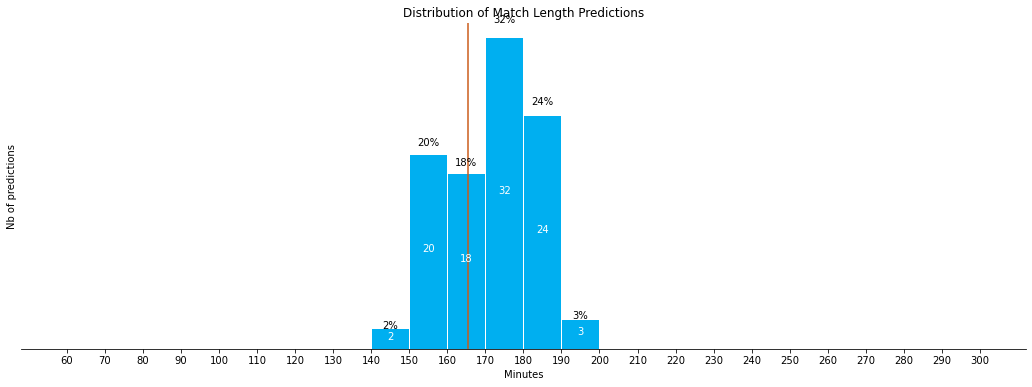

In [346]:
### HISTOGRAM ###

# ATP Colors
# Dark blue : #002865
# Light blue : #00AFF0
# Rolland Garros Orange : #CB5A19

time_step = 10  # precision : 15/30/30 minutes
intervals=np.arange(60, 300 + time_step, time_step)

fig, ax = plt.subplots(1, figsize=(18,6))

n, bins, patches = plt.hist(predictions, bins=intervals, color='#00AFF0')

plt.xticks(bins)
plt.grid(color='white', lw = 1, axis='x')

plt.title('Distribution of Match Length Predictions')
plt.xlabel("Minutes")
plt.ylabel("Nb of predictions")

# ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

xticks = [(bins[idx+1] + value)/2 for idx, value in enumerate(bins[:-1])]
plt.yticks([])

for idx, value in enumerate(n) :
    if value > 0 :
        plt.text(xticks[idx], value * 1.05, f"{int(100 * value / iter)}%", ha='center')
        plt.text(xticks[idx], value / 2, int(value), ha='center', color='w')

plt.axvline(x=average_prediction, color='#CB5A19')